In [45]:
# Initialize Otter
import otter
grader = otter.Notebook("hw07.ipynb")

<a id="top"></a>

# Homework 7: IMDb and U.S. Presidential Elections
## SQL + PCA
## Due Date: Monday, August 1, 11:59 PM PDT

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** below.

**Collaborators**: *list collaborators here*



## Introduction

This homework has two disjoint parts:

**Part 1:** We will use SQL to dive deep into the Internet Movie Database (IMDb) and answer different questions involving movies, actors, and movie ratings. [Click here to jump to Part 1](#part-1).

**Part 2:** We will use Principal Component Analysis to understand a high-dimensional dataset: U.S. Presidential Elections by State. [Click here to jump to Part 2](#part-2).

## Grading
Grading is broken down into autograded answers and free response. For autograded answers, the results of your code are compared to provided and/or hidden tests. For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

<!--
<details>
    <summary>[Click to Expand] <b>Scoring Breakdown</b></summary>-->
|Question|Points|
|---|---|
|Q1a | 2 |
|Q1b | 2 |
|Q2 | 3 |
|Q3 | 3 |
|Q4 | 4 |
|Q5 | 4 |
|Q6a | 1 |
|Q6b | 1 |
|Q6c | 1 |
|Q6d | 1 |
|Q6e | 2 |
|Q7a | 2 |
|Q7b | 2 |
|Q8a | 1 |
|Q8b | 2 |
|Q8c | 2 |
|Total | 33 |
</details>

In [46]:
# Run this cell to set up your notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sqlalchemy
from pathlib import Path

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
np.set_printoptions(threshold=5) # avoid printing out big matrices
%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<br/><br/>

---
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

---

<a id='part-1'></a>
# Part 1: The IMDB (mini) Dataset


(Click [here](#top) to jump back to the top of this notebook.)

We will explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we used for this week's lab. The remainder of this overview section is copied from this week's lab.

Let's load in the database in two ways (using both Python and cell magic) so that we can flexibly explore the SQL database.

A few reminders: 
* **Only SQL code written with `pd.read_sql` will be graded.**  You should feel free to create `%%sql` cells **after** your Python answer + autograder cells to reduce debugging headaches, but you will still need to copy over any SQL to the Python answer cells. **Do not** add new cells betwen the question and the grading cells; it will cause errors when we run the autograder, and it will sometimes cause an error in generating the PDF file.

* **Caution: Be careful with large SQL queries!!** You may need to reboot your Jupyter Hub instance if it stops responding. **Use the LIMIT keyword** to avoid printing out 100k-sized tables (but remember to remove it).

* Films and movies are equivalent ways of expressing the condition that `titleType = 'movie'`, and they are used interchangeably throughout the assignment. They refer to the same thing!

In [47]:
# run this cell and the next one
engine = sqlalchemy.create_engine("sqlite:///data/imdbmini.db")
connection = engine.connect()

In [48]:
%sql sqlite:///data/imdbmini.db

<br/>

Let's take a look at the table schemas:

In [49]:
%%sql
-- just run this cell --
SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///data/imdbmini.db
Done.


type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (text) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (integer) – in YYYY format
- deathYear (integer) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given tconst
- nconst (text) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- averageRating (text) – weighted average of all the individual user ratings
- numVotes (text) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the filmmakers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- startYear (text) – represents the release year of a title.
- runtimeMinutes (integer)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>
From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1

### Question 1a
How far back does our data go? Does it only include recent data, or do we have information about older movies and movie stars as well? 

List the **10 oldest `movie` titles** by `startYear` and then `primaryTitle` both in **ascending** order.  Do not include films where the `startYear` is `NULL`.  The output should contain the `startYear`, `primaryTitle`, and `titleType`.

Remember, you can create a `%%sql` cell **after** the grader cell as scratch work. Just be sure to copy the query back into the Python cell to run the autograder.

<!--
BEGIN QUESTION
name: q1a
points: 2
-->

In [50]:
query_q1a = """
SELECT startYear, primaryTitle, titleType
FROM Title
WHERE titleType='movie'
ORDER BY startYear, primaryTitle ASC
LIMIT 10;
"""


res_q1a = pd.read_sql(query_q1a, engine)
res_q1a

,startYear,primaryTitle,titleType
0,1915,The Birth of a Nation,movie
1,1920,The Cabinet of Dr. Caligari,movie
2,1921,The Kid,movie
3,1922,Nosferatu,movie
4,1924,Sherlock Jr.,movie
5,1925,Battleship Potemkin,movie
6,1925,The Gold Rush,movie
7,1926,The General,movie
8,1927,Metropolis,movie
9,1927,Sunrise,movie


In [51]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 1b

Next, let's calculate the distribution of films by year. Write a query that returns the **total** `movie` titles for each `startYear` in the `Title` table as `total`.  Keep in mind that some entries may not have a `startYear` listed -- you should filter those out.  Order your final results by the `startYear` in **ascending** order.

The first few records of the table should look like the following (but you should compute the entire table).


| |startYear|total|
|-----|------|-----|
|**0**|1915|1|
|**1**|1920|1|
|**2**|1921|1|
|**3**|1922|1|
|...|...|...|


<!--
BEGIN QUESTION
name: q1b
points: 2
-->

In [52]:
query_q1b = """
SELECT startYear, COUNT(titleType) as total
FROM Title
WHERE NOT startYear='--' AND titleType='movie'
GROUP BY startYear
ORDER BY startYear ASC;
"""


res_q1b = pd.read_sql(query_q1b, engine)
res_q1b

,startYear,total
0,1915,1
1,1920,1
2,1921,1
3,1922,1
4,1924,1
...,...,...
97,2017,213
98,2018,230
99,2019,194
100,2020,117


In [53]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

The following should generate an interesting plot of the number of films that premiered each year. Notice there is a dip between the 1920s and late 1940s. Why might that be? *This question is rhetorical; you do not need to write your answer anywhere.*

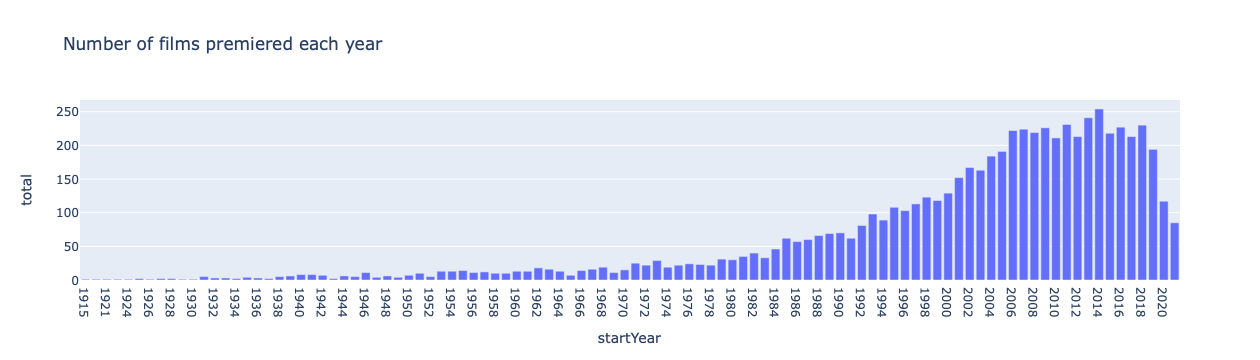

In [54]:
# just run this cell
px.bar(res_q1b, x="startYear", y="total",
       title="Number of films premiered each year")

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 2

Who are the **top 10 most prolific movie actors**?

Define the term "movie actor" is defined as anyone with an `actor` or `actress` job category role in a `movie` title.

Your SQL query should output exactly two fields named `name` (the movie actor name) and `total` (the number of movies the movie actor appears in). Order the records by `total` in descending order, and break ties by ordering by `name` in ascending order.

Your result should look something like the following, but without `????`:

| | name | total |
|-----|-----|-----|
|**0**| ???? | 64 |
|**1**| ???? | 54 |
|**2**| ???? | 53 |
|**3**| ???? | 49 |
|**4**| ???? | 46 |
|**5**| ???? | 43 |
|**6**| ???? | 41 |
|**7**| ???? | 40 |
|**8**| ???? | 40 |
|**9**| ???? | 39 |

Some hints: 

* ***The query should take < 2 minutes to run.***
* Google the top of the list and see if it makes sense.
* If you want to include a non-aggregate field in the `SELECT` clause, it must also be included in the `GROUP BY` clause.
<!--* You can assume each movie actor only has one role per film. If you're not sure how this hint affects your query, ignore this hint.-->

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [55]:
query_q2 = """
SELECT primaryName as name, COUNT(Title.tconst) as total
FROM Name
JOIN Role on Name.nconst = Role.nconst
JOIN Title on Role.tconst = Title.tconst
WHERE (category = 'actor' OR category = 'actress') AND titleType ='movie'
GROUP BY primaryName
ORDER BY total DESC
LIMIT 10
"""


res_q2 = pd.read_sql(query_q2, engine)
res_q2

,name,total
0,Robert De Niro,64
1,Samuel L. Jackson,54
2,Nicolas Cage,53
3,Bruce Willis,49
4,Tom Hanks,46
5,Johnny Depp,43
6,Mark Wahlberg,41
7,Morgan Freeman,40
8,Liam Neeson,40
9,Sylvester Stallone,39


In [56]:
grader.check("q2")

q2 results: All test cases passed!

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 3: The `CASE` Keyword

The `Rating` table has the `numVotes` and the `averageRating` for each title. Which `movie` titles were **"big hits"**, defined as a movie with over 100,000 votes? Construct the following table:

| | isBigHit | total |
|-----|-----|-----|
|**0**| no | ???? |
|**1**| yes | ???? |

Where `????` is replaced with the correct values. The row with `no` should have the count for how many movies **are not** big hits, and the row with `yes` should have the count of how many movies **are** big hits.

* Rating.numVotes currently consists of string objects, use `CAST(Rating.numVotes AS int)` to convert them to integer.
* You will need to use  some type of `JOIN`.
* You may also consider using a `CASE WHEN ... IS ... THEN 'yes' ... ELSE ... END` statement. `CASE` statements are the SQL-equivalent of Python `if... elif... else` statements. To read up on `CASE`, take a look at the following links:
    - https://mode.com/sql-tutorial/sql-case/
    - https://www.w3schools.com/sql/sql_ref_case.asp

<!--
BEGIN QUESTION
name: q3
manual: false
points: 3
-->

In [57]:
query_q3 = """
SELECT
CASE WHEN CAST(Rating.numVotes AS int) > 100000 THEN "yes" 
ELSE "no" 
END isBigHit,
COUNT(*) as total
FROM Rating
JOIN Title ON Rating.tconst = Title.tconst
WHERE titleType = 'movie'
GROUP BY isBigHit
"""


res_q3 = pd.read_sql(query_q3, engine)
res_q3

,isBigHit,total
0,no,4318
1,yes,2041


In [58]:
grader.check("q3")

q3 results: All test cases passed!

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 4

**How does film length relate to ratings?**  To answer this question we want to bin `movie` titles by length and compute the average of the average ratings within each length bin. We will group movies by 10-minute increments -- that is, one bin for movies \[0, 10) minutes long, another for \[10, 20) minutes, another for \[20, 30) minutes, and so on. Use the following code snippet to help construct 10-minute bins: 

```
ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin
```

Construct a table containing the **`runtimeBin`**, the **average** of the **average ratings** (as `averageRating`), the **average number of votes** (as `averageNumVotes`), and the number of `titles` in that **runtimeBin** (as `total`).  Only include movies with **at least 10000 votes**.  Order the final results by the value of `runtimeBin`.

<!--
BEGIN QUESTION
name: q4
manual: false
points: 4
-->

In [59]:
query_q4 = """
SELECT ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin, AVG(averageRating) as averageRating, AVG(numVotes) as averageNumVotes, COUNT(primaryTitle) as total
FROM Title
JOIN Rating on Title.tconst = Rating.tconst
WHERE CAST(numVotes AS int) >= 10000 AND titleType = 'movie'
GROUP BY runtimeBin
ORDER BY runtimeBin
"""


res_q4 = pd.read_sql(query_q4, engine)
res_q4.head()

,runtimeBin,averageRating,averageNumVotes,total
0,50.0,7.850000,42535.000000,2
1,60.0,6.400000,30668.500000,2
2,70.0,7.600000,59822.000000,13
3,80.0,6.860937,67896.187500,64
4,90.0,6.283951,76907.608466,567


In [60]:
grader.check("q4")

q4 results: All test cases passed!

<br/>

If your SQL query is correct you should get some interesting plots below.  This might explain why directors keep going a particular direction with film lengths.  

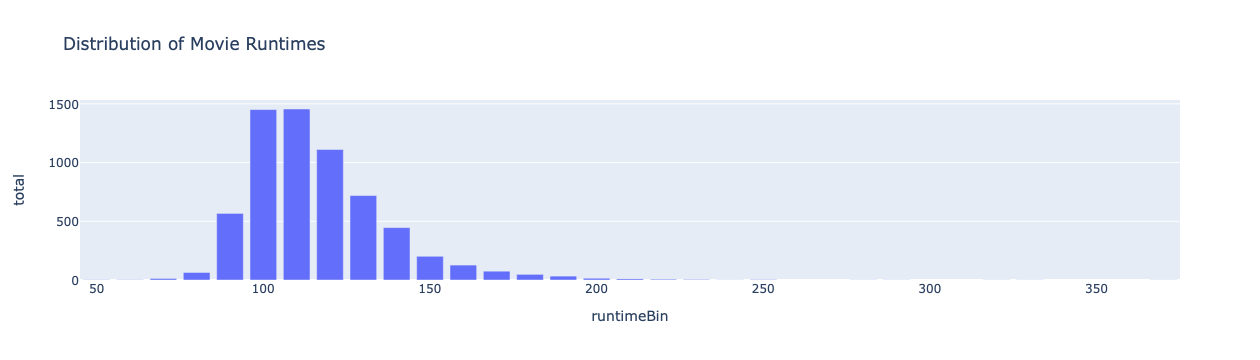

In [61]:
# just run this cell
px.bar(res_q4, x="runtimeBin", y="total",
       title="Distribution of Movie Runtimes")

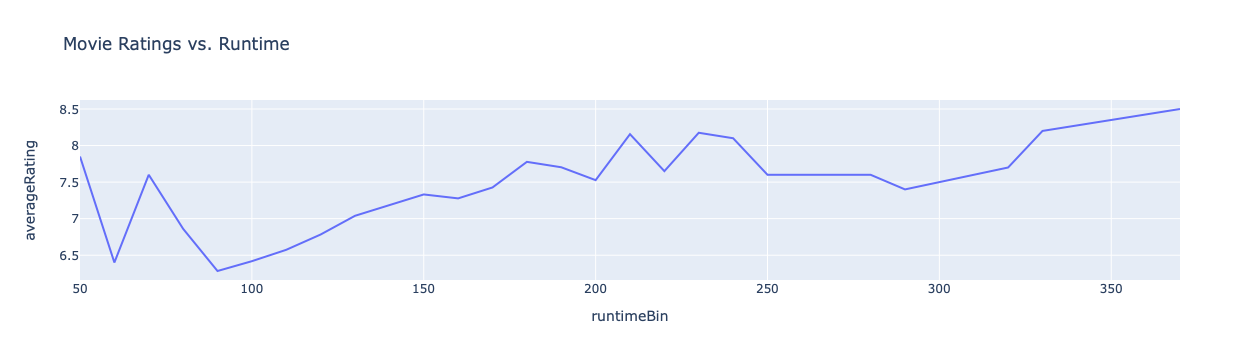

In [62]:
# just run this cell
px.line(res_q4, x="runtimeBin", y="averageRating",
        title="Movie Ratings vs. Runtime")

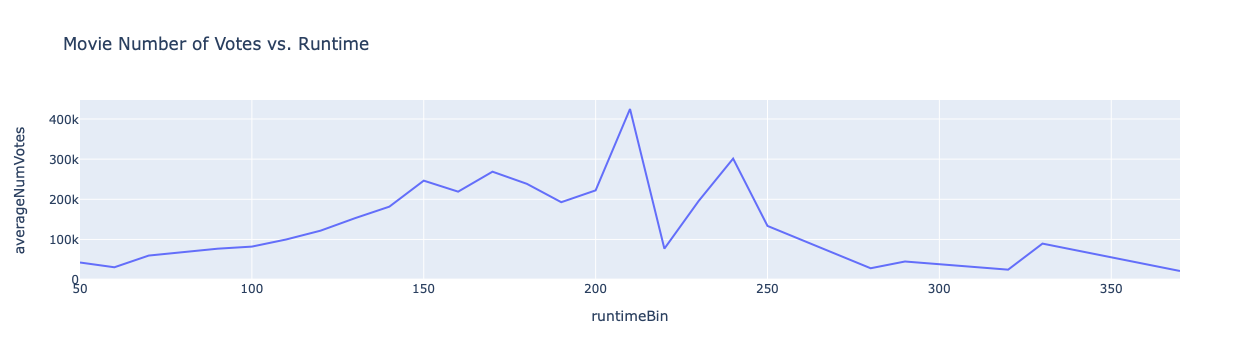

In [63]:
px.line(res_q4, x="runtimeBin", y="averageNumVotes",
        title="Movie Number of Votes vs. Runtime")

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 5


Which **movie actors** have the highest average ratings across all the **movies** in which they star? Again, define "movie actor" as anyone with an `actor` or `actress` job category role in a `movie` title.

Construct a table consisting of the **movie actor's name**  (as `name`) and their **average actor rating** (as `actorRating`) computed by rescaling ratings for movies in which they had a role:

$$
\text{actorRating} = 
\frac{\sum_m \text{averageRating}[m] * \text{numVotes}[m]}{\sum_m \text{numVotes}[m]}
$$

Some notes:
* Note that if an actor/actress has multiple `role` listings for a film then that film will have a bigger impact in the overall average (this is desired).
* ***The query should take < 3 minutes to run.***
* Only consider ratings where there are **at least 1000** votes and only consider movie actors that have **at least 20 rated performances**. Present the movie actors with the **top 10** `actorRating` in descending order and break ties alphabetically using the movie actor's name.

The results should look something like this but without the `????`, and with higher rating precision.

| | name | actorRating |
|-----|-----|-----|
|**0**|????|8.4413...|
|**1**|????|8.2473...|
|**2**|????|8.1383...|
|**3**|????|8.1339...|
|**4**|????|8.0349...|
|**5**|????|7.9898...|
|**6**|????|7.9464...|
|**7**|????|7.9330...|
|**8**|????|7.9261...|
|**9**|????|7.8668...|


<!--
BEGIN QUESTION
name: q5
manual: false
points: 4
-->

In [64]:
query_q5 = """
SELECT primaryName as name, SUM(Rating.averageRating * Rating.numVotes)/ SUM(Rating.numVotes) as actorRating
FROM Name
JOIN Role on Name.nconst = Role.nconst
JOIN Rating on Role.tconst = Rating.tconst
JOIN Title on Rating.tconst = Title.tconst
WHERE (category = 'actor' OR category = 'actress') AND titleType ='movie' AND CAST(numVotes AS int) >= 1000
GROUP BY primaryName
HAVING COUNT(primaryName) >= 20
ORDER BY actorRating DESC
LIMIT 10
"""


res_q5 = pd.read_sql(query_q5, engine)
res_q5

,name,actorRating
0,Diane Keaton,8.441302
1,Tim Robbins,8.247318
2,Al Pacino,8.138361
3,Michael Caine,8.133915
4,Leonardo DiCaprio,8.034961
5,Christian Bale,7.989825
6,Robert Duvall,7.946483
7,Jack Nicholson,7.933034
8,Kevin Spacey,7.926158
9,Clint Eastwood,7.866839


In [65]:
grader.check("q5")

q5 results: All test cases passed!

<br/><br/><br/>

---
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

---

<a id='part-2'></a>
# Part 2: U.S. Presidential Elections By State

(Click [here](#top) to jump back to the top of this notebook.)

The second part of this homework focuses on a new dataset. If you haven't worked with Principal Component Analysis before, we highly encourage you to take a look at the PCA lab first. PCA really shines on data where you have reason to believe that the data is relatively low in rank. 

We'll look at how states voted in presidential elections between 1972 and 2016. **Our ultimate goal in this part is to show how 2D PCA scatterplots can allow us to identify clusters in a high dimensional dataset.** For this example, that means finding groups of states that vote similarly by plotting their 1st and 2nd principal components.

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 6

We explore a dataset on U.S. Presidential Elections by State since 1789, as taken from [Wikipedia](https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state).

In [66]:
df = pd.read_csv("data/presidential_elections.csv")
df.head(5)

,State,1789,1792,1796,1800 †,Unnamed: 5,1804,1808,1812,1816,...,1992,1996,2000 ‡,Unnamed: 60,2004,2008,2012,2016 ‡,2020,State.1
0,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,R,R,R,NaN,R,R,R,R,R,Alabama
1,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,R,R,R,NaN,R,R,R,R,R,Alaska
2,Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,R,D,R,NaN,R,R,R,R,D,Arizona
3,Arkansas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D,D,R,NaN,R,R,R,R,R,Arkansas
4,California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D,D,D,NaN,D,D,D,D,D,California


The data in this table is pretty messy (missing records, inconsistent field naming, etc.), so let's create a clean version.

Running the cell below will produce a clean table, which contains exactly 51 rows (corresponding to the 50 states plus Washington DC) and 13 columns (one for each of the election years from 1972 to 2020). The index of this dataframe is the state name.

In [67]:
# just run this cell
df_clean = ( 
        df.iloc[:, -15:]    
        .drop(['Unnamed: 60'], axis = 1) 
        .rename(columns = {"2000 ‡": "2000", "2016 ‡": "2016", "State.1": "State"}) 
        .drop([51]) 
        .set_index("State")
)
df_clean

,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016,2020
State,,,,,,,,,,,,,
Alabama,R,D,R,R,R,R,R,R,R,R,R,R,R
Alaska,R,R,R,R,R,R,R,R,R,R,R,R,R
Arizona,R,R,R,R,R,R,D,R,R,R,R,R,D
Arkansas,R,D,R,R,R,D,D,R,R,R,R,R,R
California,R,R,R,R,R,D,D,D,D,D,D,D,D
Colorado,R,R,R,R,R,D,R,R,R,D,D,D,D
Connecticut,R,R,R,R,R,D,D,D,D,D,D,D,D
Delaware,R,D,R,R,R,D,D,D,D,D,D,D,D
D.C.,D,D,D,D,D,D,D,D,D,D,D,D,D


Side note: We produced the data cleaning function chain above by inspecting the CSV file. In your personal projects, you may be tempted to use Excel or Google Sheets (What You See Is What You Get, or WYSIWYG) to clean data. While sometimes more convenient, the downside of this is that you have no record of what you did—and if you have to redownload the data, you have to redo the manual data cleaning process.

<!-- BEGIN QUESTION -->

<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 6a

What does each row in `df_clean` represent?


<!--
BEGIN QUESTION
name: q6a
manual: True
points: 1
-->

Each row represents a U.S. state

<!-- END QUESTION -->

<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 6b

To perform PCA, we need to convert our data into numerical values. Create a `df_numerical` dataframe that replaces all of the "D" characters in `df_clean` with the number 0, and all of the "R" characters with the number 1. 

*Hint:* Use `df.replace` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html)).

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [68]:
df_numerical = df_clean.replace({"D":0, "R":1})

In [69]:
grader.check("q6b")

q6b results: All test cases passed!

<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 6c

Now **standardize the data**: Center the data so that each column's mean is 0, and scale the data so that each column's variance is 1. Store your result in `df_standardized`.

**Note:** please use `np.mean` and `np.std` instead of Pandas functions!

<!--
BEGIN QUESTION
name: q6c
points: 1
-->

In [70]:
df_standardized = df_numerical - np.mean(df_numerical, axis=0)
df_standardized = df_standardized / np.std(df_standardized, axis=0)

In [71]:
grader.check("q6c")

q6c results: All test cases passed!

<br/>

We now have our data in a nice and tidy centered and scaled format. Phew! We are now ready to do PCA.

<br/>
<hr style="border: 1px solid #fdb515;" />

### Question 6d: SVD

In the following cell, compute the SVD of `df_standardized`:

$$\texttt{df}\_\texttt{standardized}=U\Sigma V^{T}$$


Store the $U$, $\Sigma$, and $V^T$ matrices in `u`, `s`, and `vt` respectively. This is one line of simple code (exactly like what we saw in lecture and what you did in lab) using the [`np.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) function with the `full_matrices` argument set to `False`.

<!--
BEGIN QUESTION
name: q6d
points: 1
-->

In [72]:
u, s, vt = np.linalg.svd(df_standardized, full_matrices = False)
u, s, vt

(array([[-0.16256283,  0.07765483,  0.00122229, ..., -0.0134597 ,
          0.08820748,  0.08217091],
        [-0.16706061, -0.0162679 , -0.12628238, ..., -0.04426333,
         -0.01355807,  0.07427217],
        [-0.09532553, -0.04755254, -0.03905914, ...,  0.45011822,
          0.13814776, -0.20684122],
        ...,
        [-0.03836168,  0.28942847,  0.23831932, ..., -0.08179345,
         -0.12580385, -0.02809131],
        [ 0.13046354,  0.02585922,  0.16202611, ...,  0.42873974,
         -0.07025696,  0.0487704 ],
        [-0.16706061, -0.0162679 , -0.12628238, ..., -0.04426333,
         -0.01355807,  0.07427217]]),
 array([18.07691752, 10.25583887,  7.64572873, ...,  2.80257708,
         2.26892781,  1.70403666]),
 array([[-0.136002  , -0.04058259, -0.15155429, ..., -0.35596474,
         -0.32690835, -0.33987784],
        [-0.3492229 , -0.48079419, -0.4675855 , ...,  0.18624495,
          0.15138213,  0.15659938],
        [ 0.41610347, -0.48658899, -0.02929042, ...,  0.03473676,
  

In [73]:
grader.check("q6d")

q6d results: All test cases passed!

<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 6e: Get Principal Components

Using your results from the previous part, create a new `first_2_pcs` **dataframe** ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)) that contains exactly the first two columns of the principal components matrix. The first column should be labeled `pc1` and the second column should be labeled `pc2`. Store your result in `first_2_pcs`, and make sure to set the index to be the default numerical range index (i.e. 0, 1, 2, ...).

<!--
BEGIN QUESTION
name: q6e
points: 2
-->

In [74]:
first_2_pcs = pd.DataFrame((u*s)[:, 0:2], columns = ["pc1", "pc2"])
first_2_pcs.head()

,pc1,pc2
0,-2.938635,0.796415
1,-3.019941,-0.166841
2,-1.723192,-0.487691
3,-1.698397,0.807836
4,2.376794,-1.807335


In [75]:
grader.check("q6e")

q6e results: All test cases passed!

<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 7

The cell below plots the 1st and 2nd principal components of our 50 states + Washington DC.

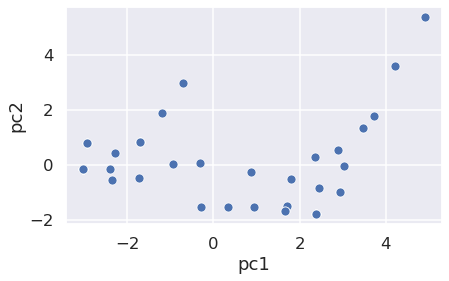

In [76]:
# just run this cell
sns.scatterplot(data = first_2_pcs, x = "pc1", y = "pc2");

<!-- BEGIN QUESTION -->

Unfortunately, we have two problems:

1. There is a lot of overplotting, with only 28 distinct dots (out of 104 points). This means that at least some states voted exactly alike in these elections.
2. We don't know which state is which because the points are unlabeled.

<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 7a: Jitter

Let's start by addressing problem 1. 

**In the cell below, create a new dataframe `first_2_pcs_jittered` with a small amount of random noise added to each principal component. In this same cell, create a scatterplot.**

To reduce overplotting, we **jitter** the first two principal components:
* Add a small amount of random, unbiased Gaussian noise to each value using `np.random.normal` ([documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)) with mean 0 and standard deviation less than 1.
* Don't get caught up on the exact details of your noise generation; it's fine as long as your plot looks roughly the same as the original scatterplot, but without overplotting.
* The amount of noise you add *should not significantly affect* the appearance of the plot; it should simply serve to separate overlapping observations.


<!--
BEGIN QUESTION
name: q3e
manual: true
points: 2
-->

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

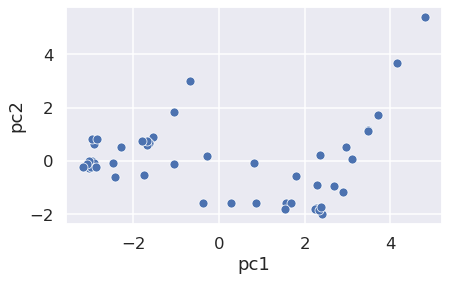

In [77]:
np.random.seed(42)
# first, jitter the data
first_2_pcs_jittered = first_2_pcs + np.random.normal(0, 0.1, first_2_pcs.shape)

# then, create a scatter plot
sns.scatterplot(data = first_2_pcs_jittered, x = "pc1", y = "pc2")

<!-- END QUESTION -->

In [78]:
first_2_pcs_jittered

,pc1,pc2
0,-2.888963,0.782589
1,-2.955172,-0.014538
2,-1.746607,-0.511105
3,-1.540476,0.884579
4,2.329846,-1.753079
5,0.281022,-1.572768
6,2.400990,-1.998663
7,2.285608,-0.900307
8,4.801990,5.404664
9,-1.032772,-0.109922


<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 7b

To address Problem 2, we can turn to Plotly. The below cell uses these Plotly guides ([example 1](https://plot.ly/python/text-and-annotations/), [example 2](https://plotly.com/python/hover-text-and-formatting/#disabling-or-customizing-hover-of-columns-in-plotly-express)) to create a scatter plot of the jittered .

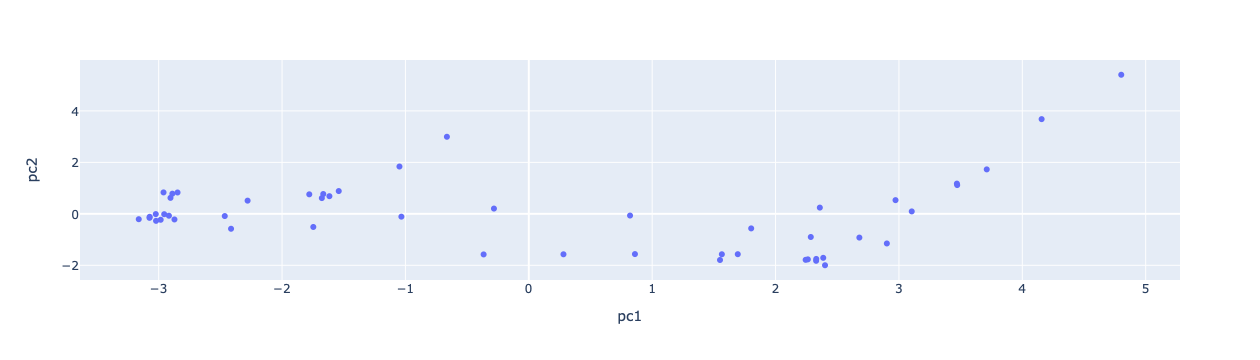

In [79]:
# just run this cell
import plotly.express as px

# get the state names from the standardized dataframe's index
first_2_pcs_jittered['state'] = df_standardized.index

# show state names on hover
fig = px.scatter(first_2_pcs_jittered, x="pc1", y="pc2",
                hover_data={"state": True}); 

fig.show(); 

<!-- BEGIN QUESTION -->

Analyze the above plot. In the below cell, address the following two points:
1. Give an example of a cluster of states that vote a similar way. Does the composition of this cluster surprise you? If you're not familiar with U.S. politics, it's fine to just say "No, I'm not surprised because I don't know anything about U.S. politics."
1. Include anything interesting that you observe. You will get credit for this as long as you write something reasonable that you can takeaway from the plot.

<!--
BEGIN QUESTION
name: q7b
manual: true
points: 2
-->

1. Maine, Illinois, New Jersey, Connecticut, Vermont. No, Im not surprised because I dont know anything about US politics.
2. The plot seems to take on a positive slope after approximately pc1 = 3, while the plots prior to this are all scattered with no specific pattern.

<!-- END QUESTION -->



<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 8

We can also look at the contributions of each year's elections results on the values for our principal components.

Below, we define the `plot_pc` function that plots and labels the rows of $V^T$. We then call this function to plot the 1st row of $V^T$, i.e., the row of $V^T$ that corresponds to `pc1`.

**Note**: If you get an error when running this cell, make sure you are properly assigning the `vt` variable from Question 6.

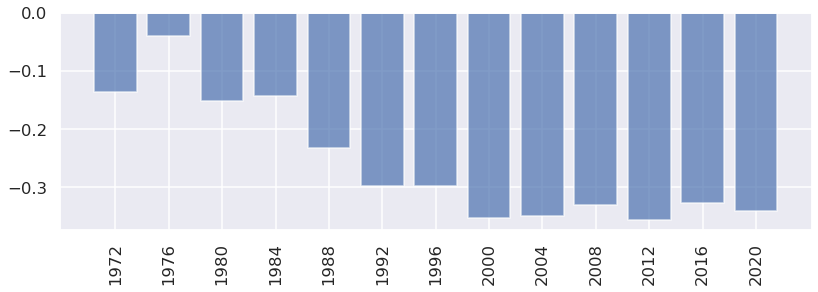

In [80]:
# just run this cell

def plot_pc(col_names, row_mat_vt, k):
    plt.bar(col_names, row_mat_vt[k, :], alpha=0.7)
    plt.xticks(col_names, rotation=90);
    
plt.figure(figsize=(12, 4)) # adjusts size of plot
plot_pc(list(df_standardized.columns), vt, 0);

<!-- BEGIN QUESTION -->


<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 8a

In the cell below, plot the the 2nd row of $V^T$, i.e., the row of $V^T$ that correpsonds to `pc2`. 

<!--
BEGIN QUESTION
name: q8a
manual: true
points: 1
-->

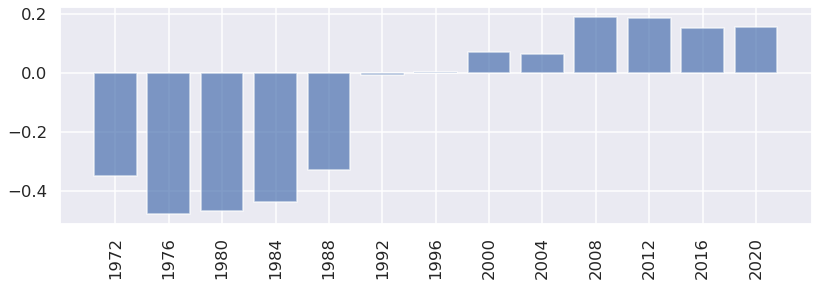

In [81]:
plt.figure(figsize=(12, 4))
plot_pc(list(df_standardized.columns), vt, 1);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->


<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 8b

Using the two above plots of the rows of $V^T$ as well as the original table, give a description of what it means for a point to be in the top-right quadrant of the 2-D scatter plot from Question 7.

In other words, what is generally true about a state with relatively large positive value for `pc1` (right side of 2-D scatter plot)? For a large positive value for `pc2` (top side of 2-D scatter plot)?

Notes:
* `pc2` is pretty hard to interpret, and the staff doesn't really have a consensus on what it means either. We'll be very nice when grading as long as your answer is reasonable - there is no correct answer necessarily. 
* Principal components beyond the first are often hard to interpret (but not always; see the lab).

<!--
BEGIN QUESTION
name: q8b
manual: true
points: 2
-->

States with a relatively large positive value are low PC1 states since they are towards the right side of the plot and of higher value, meaning that they are more republican than democrat since we represented republican with value 1.  A point in the top right quadrant of the 2D plot represents a state that is much above the PC1 line.

<!-- END QUESTION -->

In [82]:
# feel free to use this cell for scratch work. If you need more scratch space, add cells *below* this one.

# Make sure to put your actual answer in the cell above where it says "Type your answer here, replacing this text"

<!-- BEGIN QUESTION -->

<br/>
<br/>

<hr style="border: 1px solid #fdb515;" />

### Question 8c

To get a better sense of whether our 2D scatterplot captures the whole story, create a **scree plot** for this data. In other words, plot the fraction of the total variance (y-axis) captured by the ith principal component (x-axis).

*Hint:* Be sure to label your axes appropriately! You may find `plt.xticks()` ([documentation](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.xticks.html)) helpful for formatting. Also check out the lab for more on scree plots.

<!--
BEGIN QUESTION
name: q8c
manual: true
points: 2
-->

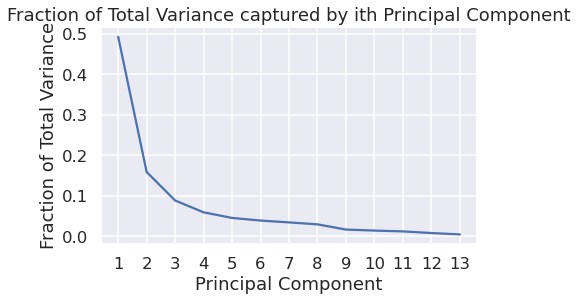

In [83]:
plt.plot(range(1, len(s) + 1), s**2 / np.sum(s**2)) 
plt.xlabel('Principal Component')
plt.xticks(range(1, len(s) + 1), range(1, len(s) + 1))
plt.ylabel('Fraction of Total Variance')
plt.title("Fraction of Total Variance captured by ith Principal Component")
plt.show()

<!-- END QUESTION -->



<br/>

From your scree plot above, you should see that the first two principal components capture a large portion of the variance in our cleaned data. It is partially for this reason that the 2D scatter plot of principal components was easy to interpret.

## Congratulations!

Congrats! You are finished with this homework assignment.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [86]:
grader.check_all()

q1a results: All test cases passed!

q1b results: All test cases passed!

q2 results: All test cases passed!

q3 results: All test cases passed!

q4 results: All test cases passed!

q5 results: All test cases passed!

q6b results: All test cases passed!

q6c results: All test cases passed!

q6d results: All test cases passed!

q6e results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [85]:
# Save your notebook first, then run this cell to export your submission.
grader.export()